<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/Smoothing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smoothing

# Install

In [1]:
!pip install statsmodels==0.13.2

# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import HoltWintersResults
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

from pylab import rcParams
rcParams['figure.figsize'] = 12,6

# Data

## Oil

In [3]:
oil_df = pd.read_csv('https://raw.githubusercontent.com/swilsonmfc/timeseries/master/us_crude_oil.csv', 
                     skiprows=5, 
                     names=['date', 'production'],
                     infer_datetime_format=True,
                     parse_dates=True,
                     index_col='date')
oil_df = oil_df.asfreq('MS')

In [4]:
oil_df

,production
date,
1920-01-01,1097
1920-02-01,1145
1920-03-01,1167
1920-04-01,1165
1920-05-01,1181
...,...
2021-10-01,11526
2021-11-01,11769
2021-12-01,11604


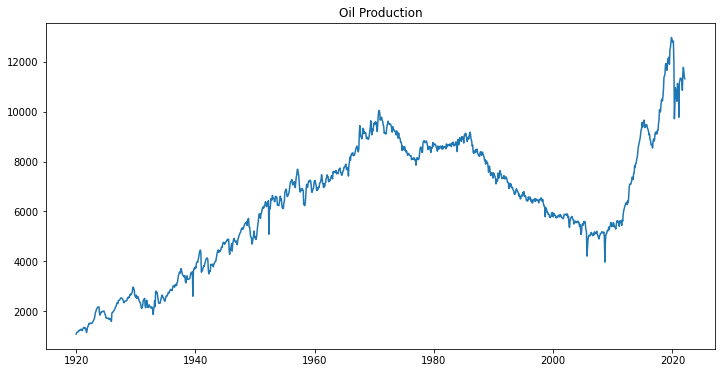

In [5]:
plt.figure(figsize=(12,6))
plt.plot(oil_df)
plt.title('Oil Production');

## Passengers

In [6]:
passengers_df = pd.read_csv('https://github.com/swilsonmfc/timeseries/raw/master/air_passengers.csv',
                           infer_datetime_format=True,
                           parse_dates=True,
                           index_col='Month')

In [7]:
passengers_df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


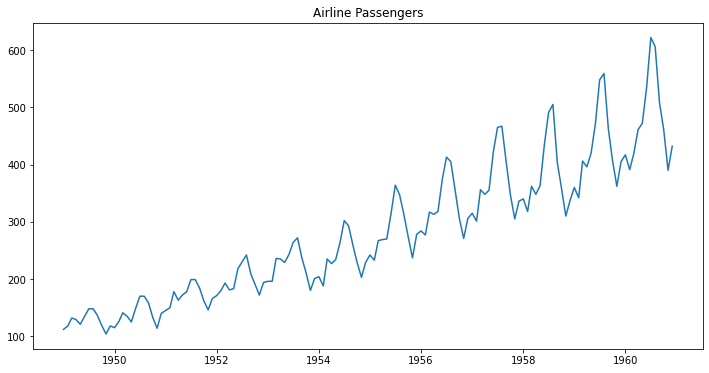

In [8]:
plt.figure(figsize=(12,6))
plt.plot(passengers_df)
plt.title('Airline Passengers');

## Sunspots

In [9]:
sunspots_df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv',
                         infer_datetime_format=True,
                         parse_dates=True,
                         index_col='Month')
sunspots_df.head()

,Sunspots
Month,
1749-01-01,58.0
1749-02-01,62.6
1749-03-01,70.0
1749-04-01,55.7
1749-05-01,85.0


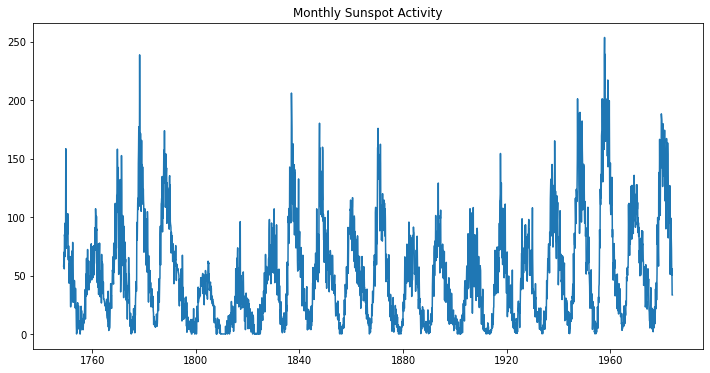

In [10]:
plt.figure(figsize=(12,6))
plt.plot(sunspots_df)
plt.title('Monthly Sunspot Activity');

# Simple Exponential Smoothing
* Appropriate if there no visible trend or seasonality
* We have two extremes
  * If we use last value (naive baseline)
  * $y_{t+1} = y_{t}$
  * If we use averaging (mean baseline)
  * $y_{t+1} = 1/T * \sum(y_{t})$
* With simple exponential smoothing, we're looking for something in between
  * $y_{t+1} = αy_{t} + (1-α)y_{t-1}$
  * Alpha is a smoothing coefficient
* Forecasts will be flat
  * All forecasted values set equal to the last level

## Level
* Higher alpha places higher weight on recent values
* Lower alpha places more weight on past values

In [11]:
smooth_df = pd.DataFrame(columns=['alpha=0.05', 'alpha=0.2', 'alpha=0.8', 'alpha=.95'])

alphas = np.array([0.05, 0.2, 0.8, 0.95])
values = alphas

for step in range(5):
  smooth_df.loc[f'Y - {step}'] = values
  values = values * (1 - alphas)
smooth_df

,alpha=0.05,alpha=0.2,alpha=0.8,alpha=.95
Y - 0,0.050000,0.20000,0.80000,0.950000
Y - 1,0.047500,0.16000,0.16000,0.047500
Y - 2,0.045125,0.12800,0.03200,0.002375
Y - 3,0.042869,0.10240,0.00640,0.000119
Y - 4,0.040725,0.08192,0.00128,0.000006


## Fit & Forecast

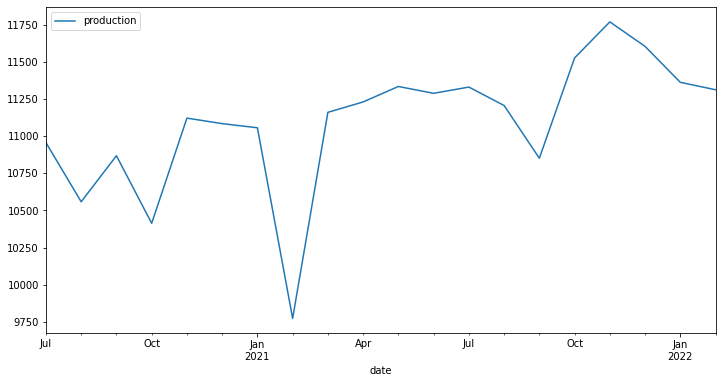

In [12]:
oil_sub_df = oil_df[-20:]
oil_sub_df.plot();

In [13]:
ses1 = SimpleExpSmoothing(oil_sub_df).fit(smoothing_level=0.0, optimized=False)
ses2 = SimpleExpSmoothing(oil_sub_df).fit(smoothing_level=0.3, optimized=False)
ses3 = SimpleExpSmoothing(oil_sub_df).fit(smoothing_level=0.6, optimized=False)
ses4 = SimpleExpSmoothing(oil_sub_df).fit(smoothing_level=1.0, optimized=False)

forecast1 = ses1.forecast(10)
forecast2 = ses2.forecast(10)
forecast3 = ses3.forecast(10)
forecast4 = ses4.forecast(10)

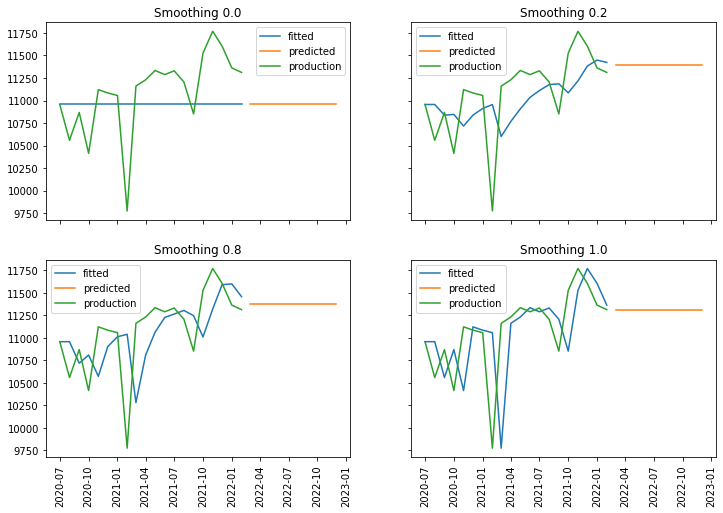

In [14]:
def plot_ax(ax, oil, fitted, predicted, title):
  ax.plot(fitted, label='fitted')
  ax.plot(predicted, label='predicted')
  ax.plot(oil, label='production')
  ax.set_title(title)
  ax.legend()

fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
ax[1,0].tick_params('x', labelrotation=90)
ax[1,1].tick_params('x', labelrotation=90)
plot_ax(ax[0,0], oil_sub_df, ses1.fittedvalues, forecast1, 'Smoothing 0.0')
plot_ax(ax[0,1], oil_sub_df, ses2.fittedvalues, forecast2, 'Smoothing 0.2')
plot_ax(ax[1,0], oil_sub_df, ses3.fittedvalues, forecast3, 'Smoothing 0.8')
plot_ax(ax[1,1], oil_sub_df, ses4.fittedvalues, forecast4, 'Smoothing 1.0')

## Optimization

In [15]:
oil_sub_df = oil_df[-20:]
ses = SimpleExpSmoothing(oil_sub_df).fit(optimized=True)
ses.summary()

Dep. Variable:,production,No. Observations:,20
Model:,SimpleExpSmoothing,SSE,3430690.597
Optimized:,True,AIC,245.051
Trend:,None,BIC,247.042
Seasonal:,None,AICC,247.717
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2525819,alpha,True
initial_level,10826.797,l.0,True


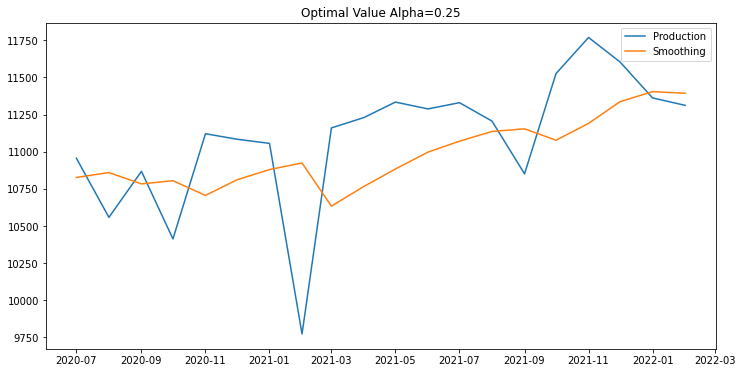

In [16]:
plt.plot(oil_sub_df, label='Production')
plt.plot(ses.fittedvalues, label='Smoothing');
plt.title(f'Optimal Value Alpha={ses.params["smoothing_level"]:.2f}')
plt.legend();

# Holt
* Holt extends simple exponential smoothing to include trend

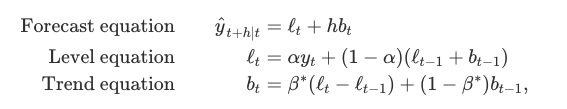

## Level and Trend
* Alpha - Like Simple Exponential Smoothing - Controls for level
* Beta - Controls for slope (trend)

## Fit & Forecast

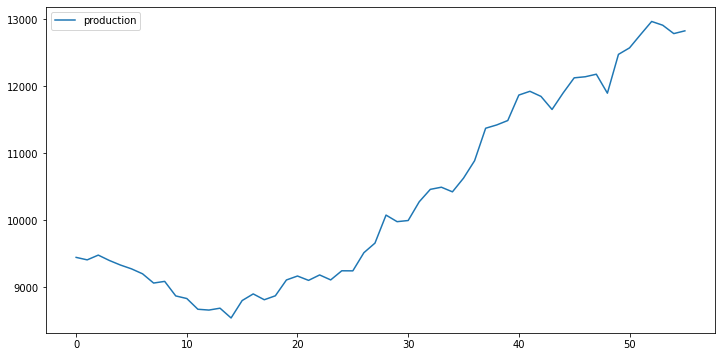

In [17]:
oil_sub_df = oil_df[-80:-24].copy().reset_index(drop=True)
oil_sub_df.plot()

In [18]:
holt1 = Holt(oil_sub_df)
holt2 = Holt(oil_sub_df)
holt3 = Holt(oil_sub_df)
holt4 = Holt(oil_sub_df)

hf1 = holt1.fit(smoothing_level=0.2, smoothing_trend=0.2, optimized=False)
hf2 = holt2.fit(smoothing_level=0.4, smoothing_trend=0.4, optimized=False)
hf3 = holt3.fit(smoothing_level=0.6, smoothing_trend=0.6, optimized=False)
hf4 = holt4.fit(smoothing_level=0.8, smoothing_trend=0.8, optimized=False);

In [19]:
start = len(oil_sub_df)
periods = 12

forecast1 = holt1.predict(holt1.params, start=start, end=start+periods)
forecast1_df = pd.DataFrame(forecast1).set_index(np.array([x for x in range(start, start+periods+1)]))
forecast2 = holt2.predict(holt2.params, start=start, end=start+periods)
forecast2_df = pd.DataFrame(forecast2).set_index(np.array([x for x in range(start, start+periods+1)]))
forecast3 = holt3.predict(holt3.params, start=start, end=start+periods)
forecast3_df = pd.DataFrame(forecast3).set_index(np.array([x for x in range(start, start+periods+1)]))
forecast4 = holt4.predict(holt4.params, start=start, end=start+periods)
forecast4_df = pd.DataFrame(forecast4).set_index(np.array([x for x in range(start, start+periods+1)]))

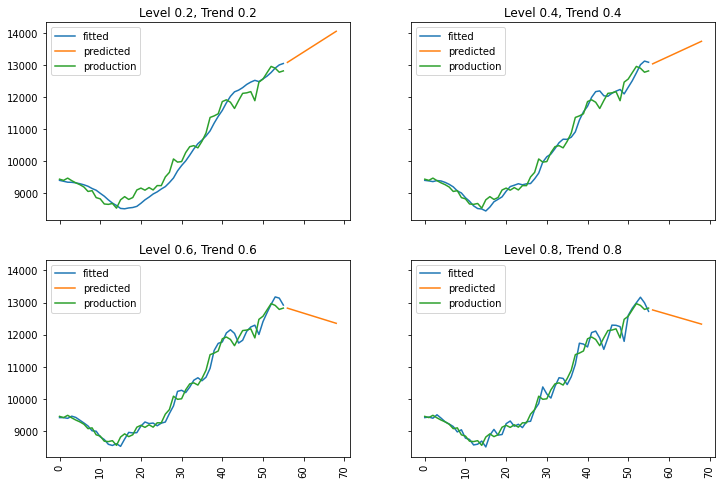

In [20]:
def plot_ax(ax, oil, fitted, predicted, title):
  ax.plot(fitted, label='fitted')
  ax.plot(predicted, label='predicted')
  ax.plot(oil, label='production')
  ax.set_title(title)
  ax.legend()

fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
ax[1,0].tick_params('x', labelrotation=90)
ax[1,1].tick_params('x', labelrotation=90)
plot_ax(ax[0,0], oil_sub_df, hf1.fittedvalues, forecast1_df, 'Level 0.2, Trend 0.2')
plot_ax(ax[0,1], oil_sub_df, hf2.fittedvalues, forecast2_df, 'Level 0.4, Trend 0.4')
plot_ax(ax[1,0], oil_sub_df, hf3.fittedvalues, forecast3_df, 'Level 0.6, Trend 0.6')
plot_ax(ax[1,1], oil_sub_df, hf4.fittedvalues, forecast4_df, 'Level 0.8, Trend 0.8')

## Optimization

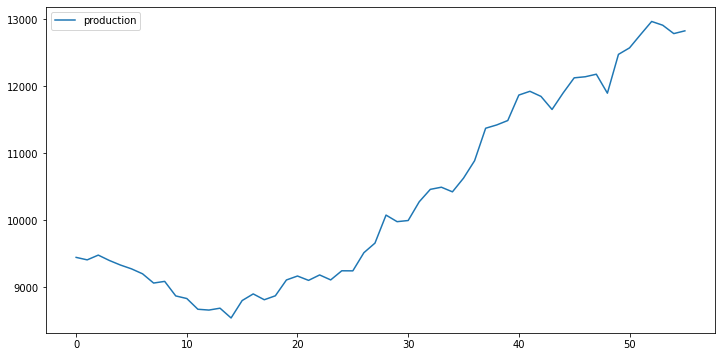

In [21]:
oil_sub_df = oil_df[-80:-24].copy().reset_index(drop=True)
oil_sub_df.plot()

In [22]:
holt_opt = Holt(oil_sub_df).fit(optimized=True)
holt_opt.summary()

Dep. Variable:,production,No. Observations:,56
Model:,Holt,SSE,1649700.653
Optimized:,True,AIC,584.282
Trend:,Additive,BIC,592.384
Seasonal:,None,AICC,585.996
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:24
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9101272,alpha,True
smoothing_trend,0.1173771,beta,True


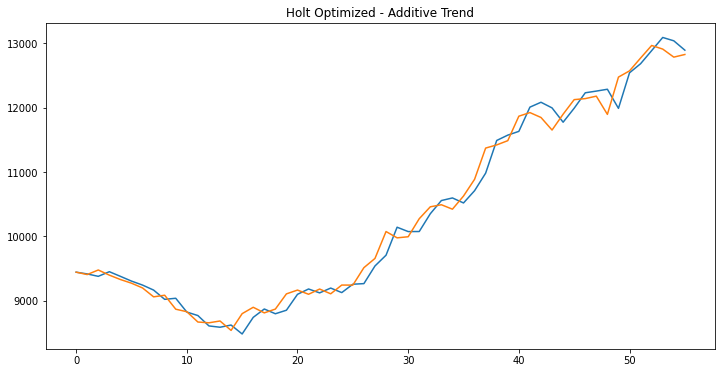

In [23]:
plt.plot(holt_opt.fittedvalues)
plt.plot(oil_sub_df)
plt.title('Holt Optimized - Additive Trend');

## Exponential
* Holt models can have a multiplicative trend
* This can help capture trends growing or decreasing at exponential rates

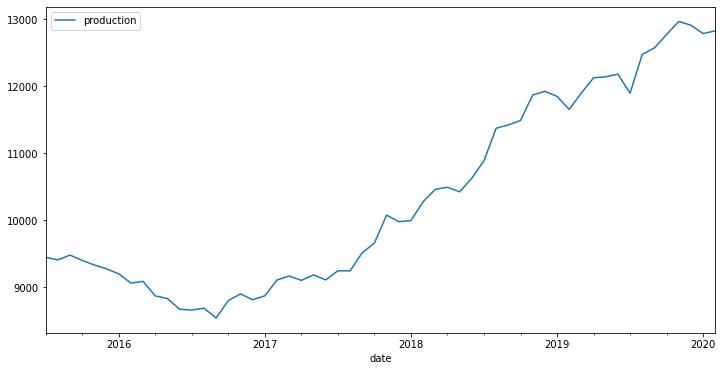

In [24]:
oil_sub_df = oil_df[-80:-24]
oil_sub_df.plot()

In [25]:
holt_exp = Holt(oil_sub_df, exponential=True).fit(optimized=True)
holt_exp.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Dep. Variable:,production,No. Observations:,56
Model:,Holt,SSE,1665572.981
Optimized:,True,AIC,584.818
Trend:,Multiplicative,BIC,592.920
Seasonal:,None,AICC,586.533
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9242857,alpha,True
smoothing_trend,0.1127178,beta,True


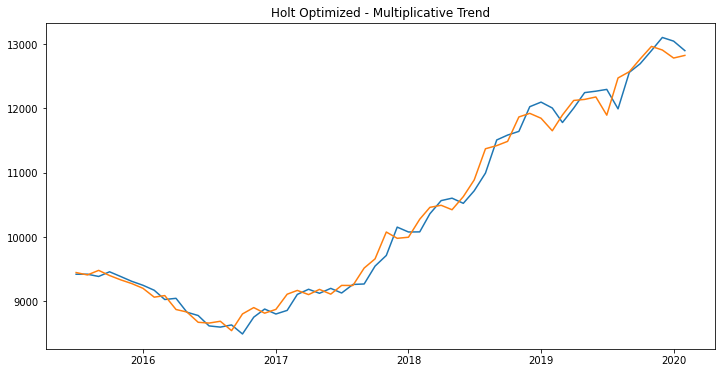

In [26]:
plt.plot(holt_exp.fittedvalues)
plt.plot(oil_sub_df)
plt.title('Holt Optimized - Multiplicative Trend');

## Dampening

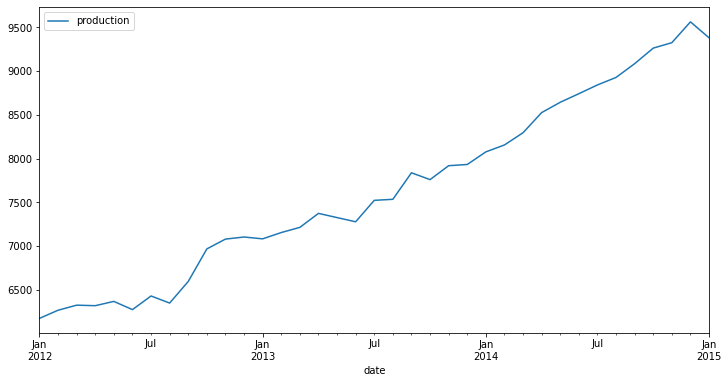

In [27]:
oil_sub_df = oil_df['2012-01-01': '2015-01-01']
oil_sub_df.plot();

In [28]:
holt_base = Holt(oil_sub_df)
holt_base.fit(smoothing_level=0.8, 
              smoothing_trend=0.2, 
              optimized=False)

holt_damp = Holt(oil_sub_df, damped_trend=True)
holt_damp.fit(smoothing_level=0.8, 
              smoothing_trend=0.2, 
              damping_trend=.95, 
              optimized=False);

In [29]:
start = len(oil_sub_df)
periods = 24

forecast_base = holt_base.predict(holt_base.params, start=start, end=start+periods)
forecast_damp = holt_damp.predict(holt_damp.params, start=start, end=start+periods)

forecast_base_df = pd.DataFrame(forecast_base).set_index(pd.date_range('2015-02-01', 
                                                                       periods=periods + 1, freq='MS'))
forecast_damp_df = pd.DataFrame(forecast_damp).set_index(pd.date_range('2015-02-01', 
                                                                       periods=periods + 1, freq='MS'))

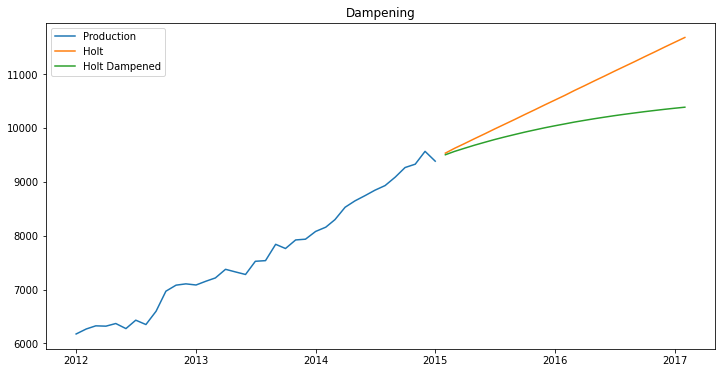

In [30]:
plt.plot(oil_sub_df, label='Production')
plt.plot(forecast_base_df, label='Holt')
plt.plot(forecast_damp_df, label='Holt Dampened')
plt.title(f'Dampening')
plt.legend();

# Holt Winters
* Holt-Winters extends Holt 
* Adds seasonality
* Includes Dampening

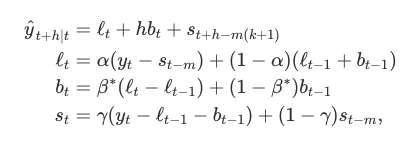

## Level, Trend and Seasonality
* Alpha - Like Simple Exponential Smoothing - Controls for level
* Beta - Like Holt - Controls for slope (trend)
  * Additive
  * Multiplicative
* Gamma - Controls for Seasonality
  * Additive
  * Multiplicative
  * Number of Seasonal Periods

## Optimization

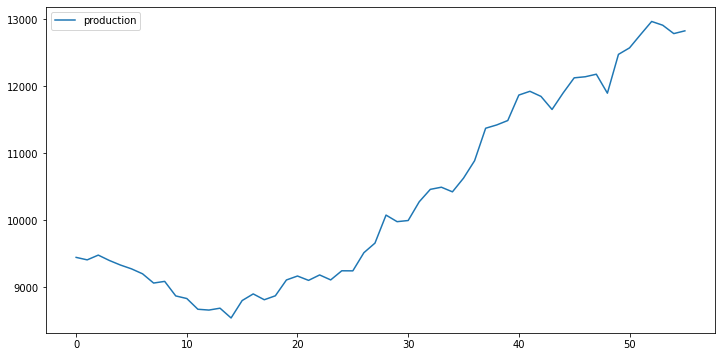

In [31]:
oil_sub_df = oil_df[-80:-24].copy().reset_index(drop=True)
oil_sub_df.plot()

In [32]:
hw_opt = ExponentialSmoothing(oil_sub_df)
hw_opt_fit = hw_opt.fit(optimized=True)
hw_opt_fit.summary()

Dep. Variable:,production,No. Observations:,56
Model:,ExponentialSmoothing,SSE,1925625.770
Optimized:,True,AIC,588.943
Trend:,None,BIC,592.994
Seasonal:,None,AICC,589.727
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,9595.2000,l.0,True


In [33]:
hw_seas_opt = ExponentialSmoothing(oil_sub_df, 
                              seasonal='additive',
                              seasonal_periods=12)
hw_seas_opt_fit = hw_seas_opt.fit(optimized=True)
hw_seas_opt_fit.summary()

Dep. Variable:,production,No. Observations:,56
Model:,ExponentialSmoothing,SSE,1614026.856
Optimized:,True,AIC,603.058
Trend:,None,BIC,631.413
Seasonal:,Additive,AICC,617.007
Seasonal Periods:,12,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:27
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9140035,alpha,True
smoothing_seasonal,0.0060456,gamma,True


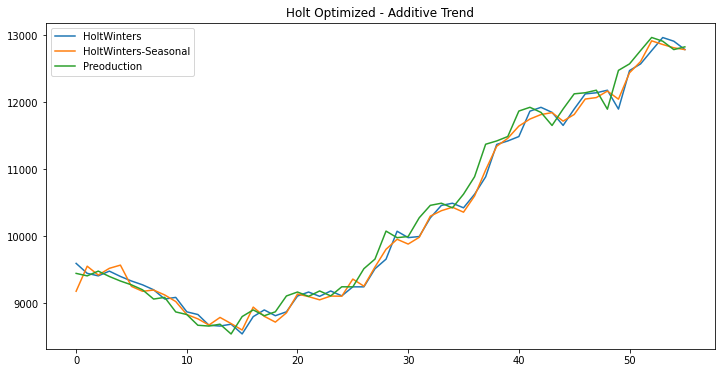

In [34]:
plt.plot(hw_opt_fit.fittedvalues, label='HoltWinters')
plt.plot(hw_seas_opt_fit.fittedvalues, label='HoltWinters-Seasonal')
plt.plot(oil_sub_df, label='Preoduction')
plt.title('Holt Optimized - Additive Trend')
plt.legend();

## Forecast

In [35]:
start = len(oil_sub_df)
periods = 12

forecast_hw    = hw_opt.predict(hw_opt_fit.params, start=start, end=start+periods)
forecast_hw_df = pd.DataFrame(forecast_hw).set_index(np.array([x for x in range(start, start+periods+1)]))

forecast_hw_seas    = hw_seas_opt.predict(hw_seas_opt_fit.params, start=start, end=start+periods)
forecast_hw_seas_df = pd.DataFrame(forecast_hw_seas).set_index(np.array([x for x in range(start, start+periods+1)]))

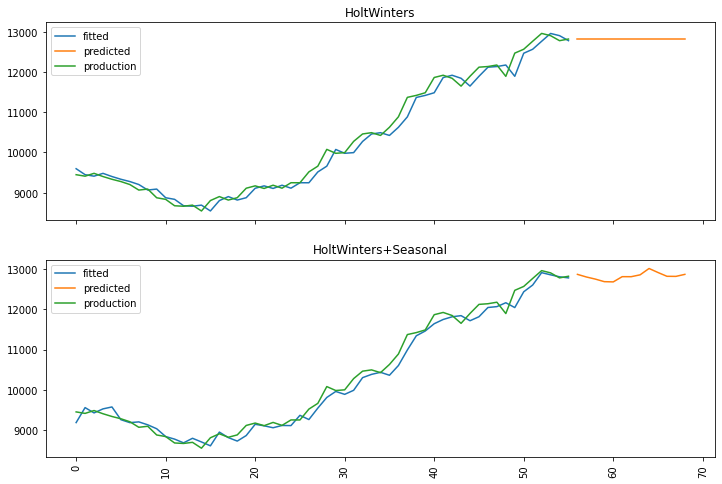

In [36]:
def plot_ax(ax, oil, fitted, predicted, title):
  ax.plot(fitted, label='fitted')
  ax.plot(predicted, label='predicted')
  ax.plot(oil, label='production')
  ax.set_title(title)
  ax.legend()

fig, ax = plt.subplots(2, figsize=(12,8), sharex=True, sharey=True)
ax[0].tick_params('x', labelrotation=90)
ax[1].tick_params('x', labelrotation=90)
plot_ax(ax[0], oil_sub_df, hw_opt_fit.fittedvalues,      forecast_hw_df,      'HoltWinters')
plot_ax(ax[1], oil_sub_df, hw_seas_opt_fit.fittedvalues, forecast_hw_seas_df, 'HoltWinters+Seasonal')

# ETSModel
* ETS models are a generalization of Simple Exponential Smoothing 
  * Error Component
  * Trend Component 
  * Seasonality Component
  * Has an underlying State Space Model
  * Interpret $Y_t$ as the result of a noisy observation of a stochastic process $X_t$ 
* Specified by
  * Error (additive or multiplicative)
  * Trend type (additive or multiplicative, both damped or undamped, or none)
  * Seasonality type (additive or multiplicative or none)
  * For example (AMN)
    * Additive Error
    * Multiplicative Trend
    * No Seasonality

## Error, Level, Trend, Seasonality

## Optimization

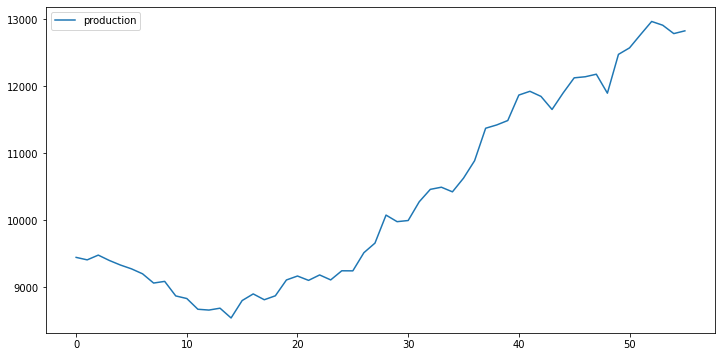

In [37]:
oil_sub_df = oil_df[-80:-24].copy().reset_index(drop=True)
oil_sub_df.plot()

In [38]:
ets_ann_opt = ETSModel(oil_sub_df.production)
ets_ann_opt_fit = ets_ann_opt.fit(maxiter=10000)
ets_ann_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:             production   No. Observations:                   56
Model:                       ETS(ANN)   Log Likelihood                -371.561
Date:                Thu, 19 May 2022   AIC                            749.122
Time:                        13:15:30   BIC                            755.198
Sample:                             0   HQIC                           751.478
                                 - 56   Scale                        33933.622
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.119      8.430      0.000       0.767       1.232
initial_level    9444.4851    184.265     51.255      0.000    9083.333    9805.637
===================================================================================
Ljung-Box (Q):                        0.35   Jarque-Bera (JB):                 5.51
Prob(Q):                              0.84   Prob(JB):                         0.06
Heteroskedasticity (H):               2.45   Skew:                             0.73
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [39]:
ets_aan_opt = ETSModel(oil_sub_df.production, trend='add')
ets_aan_opt_fit = ets_aan_opt.fit(maxiter=10000)
ets_aan_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:             production   No. Observations:                   56
Model:                       ETS(AAN)   Log Likelihood                -367.878
Date:                Thu, 19 May 2022   AIC                            745.757
Time:                        13:15:30   BIC                            755.884
Sample:                             0   HQIC                           749.683
                                 - 56   Scale                        29751.606
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.8976      0.156      5.755      0.000       0.592       1.203
smoothing_trend     0.1168      0.056      2.082      0.037       0.007       0.227
initial_level    9595.1990    174.842     54.879      0.000    9252.515    9937.883
initial_trend     -61.5832     85.046     -0.724      0.469    -228.270     105.104
===================================================================================
Ljung-Box (Q):                        1.03   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.60   Prob(JB):                         0.65
Heteroskedasticity (H):               4.35   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [40]:
ets_aaa_opt = ETSModel(oil_sub_df.production, 
                       trend='add', seasonal='add', seasonal_periods=12)
ets_aaa_opt_fit = ets_aaa_opt.fit(maxiter=10000)
ets_aaa_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:             production   No. Observations:                   56
Model:                       ETS(AAA)   Log Likelihood                -355.948
Date:                Thu, 19 May 2022   AIC                            747.895
Time:                        13:15:31   BIC                            784.352
Sample:                             0   HQIC                           762.029
                                 - 56   Scale                        19429.287
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6574      0.126      5.200      0.000       0.410       0.905
smoothing_trend         0.1579      0.049      3.200      0.001       0.061       0.255
smoothing_seasonal   3.426e-05        nan        nan        nan         nan         nan
initial_level        9479.1005   8.87e+04      0.107      0.915   -1.64e+05    1.83e+05
initial_trend         -75.7586     65.288     -1.160      0.246    -203.720      52.203
initial_seasonal.0     32.6687   8.87e+04      0.000      1.000   -1.74e+05    1.74e+05
initial_seasonal.1     97.9709   8.87e+04      0.001      0.999   -1.74e+05    1.74e+05
initial_seasonal.2    173.5082   8.87e+04      0.002      0.998   -1.74e+05    1.74e+05
initial_seasonal.3    243.7576   8.87e+04      0.003      0.998   -1.74e+05    1.74e+05
initial_seasonal.4    177.0295   8.87e+04      0.002      0.998   -1.74e+05    1.74e+05
initial_seasonal.5    194.6966   8.87e+04      0.002      0.998   -1.74e+05    1.74e+05
initial_seasonal.6    294.9262   8.87e+04      0.003      0.997   -1.74e+05    1.74e+05
initial_seasonal.7    399.1880   8.87e+04      0.004      0.996   -1.73e+05    1.74e+05
initial_seasonal.8    251.5690   8.87e+04      0.003      0.998   -1.74e+05    1.74e+05
initial_seasonal.9    185.2361   8.87e+04      0.002      0.998   -1.74e+05    1.74e+05
initial_seasonal.10   168.9264   8.87e+04      0.002      0.998   -1.74e+05    1.74e+05
initial_seasonal.11          0   8.87e+04          0      1.000   -1.74e+05    1.74e+05
===================================================================================
Ljung-Box (Q):                       24.47   Jarque-Bera (JB):                 1.97
Prob(Q):                              0.01   Prob(JB):                         0.37
Heteroskedasticity (H):               2.53   Skew:                            -0.42
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

## Forecast

In [41]:
start = len(oil_sub_df)
periods = 12

forecast_ets_ann    = ets_ann_opt_fit.predict(start=start, end=start+periods)
forecast_ets_ann_df = pd.DataFrame(forecast_ets_ann).set_index(np.array([x for x in range(start, start+periods+1)]))

forecast_ets_aan    = ets_aan_opt_fit.predict(start=start, end=start+periods)
forecast_ets_aan_df = pd.DataFrame(forecast_ets_aan).set_index(np.array([x for x in range(start, start+periods+1)]))

forecast_ets_aaa    = ets_aaa_opt_fit.predict(start=start, end=start+periods)
forecast_ets_aaa_df = pd.DataFrame(forecast_ets_aaa).set_index(np.array([x for x in range(start, start+periods+1)]))

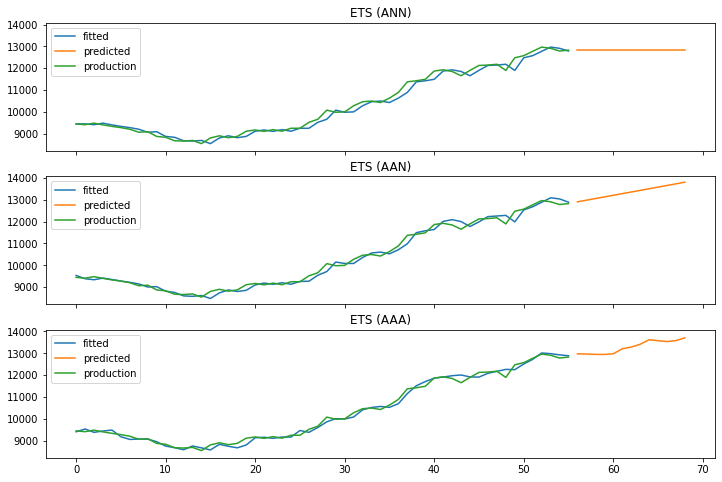

In [42]:
def plot_ax(ax, oil, fitted, predicted, title):
  ax.plot(fitted, label='fitted')
  ax.plot(predicted, label='predicted')
  ax.plot(oil, label='production')
  ax.set_title(title)
  ax.legend()

fig, ax = plt.subplots(3, figsize=(12,8), sharex=True, sharey=True)
ax[0].tick_params('x', labelrotation=90)
ax[1].tick_params('x', labelrotation=90)
plot_ax(ax[0], oil_sub_df, ets_ann_opt_fit.fittedvalues, forecast_ets_ann_df, 'ETS (ANN)')
plot_ax(ax[1], oil_sub_df, ets_aan_opt_fit.fittedvalues, forecast_ets_aan_df, 'ETS (AAN)')
plot_ax(ax[2], oil_sub_df, ets_aaa_opt_fit.fittedvalues, forecast_ets_aaa_df, 'ETS (AAA)')

## Prediction Intervals

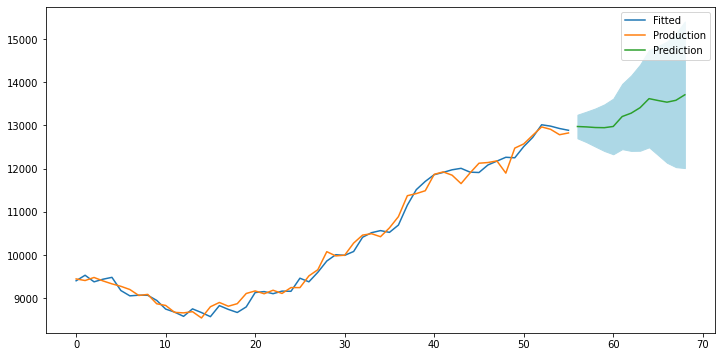

In [43]:
wrap = ets_aaa_opt_fit.get_prediction(start=start, end=start+periods)
pi_df = wrap.summary_frame()

plt.plot(ets_aaa_opt_fit.fittedvalues, label='Fitted')
plt.plot(oil_sub_df, label='Production')
plt.plot(pi_df['mean'], label='Prediction')
plt.fill_between(pi_df.index, pi_df.pi_lower, pi_df.pi_upper, color='lightblue')
plt.legend();

# Comparison - Passengers

In [44]:
compare_df = pd.DataFrame(columns=['SSE', 'AIC'])

## Simple Exponential Smoothing

In [45]:
ses = SimpleExpSmoothing(passengers_df)
ses_fit = ses.fit(optimized=True)
compare_df.loc['SimpleExponentialSmoothing'] = [ses_fit.sse, ses_fit.aic]
ses_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,#Passengers,No. Observations:,144
Model:,SimpleExpSmoothing,SSE,163003.353
Optimized:,True,AIC,1016.567
Trend:,None,BIC,1022.506
Seasonal:,None,AICC,1016.854
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:34
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950000,alpha,True
initial_level,112.00000,l.0,True


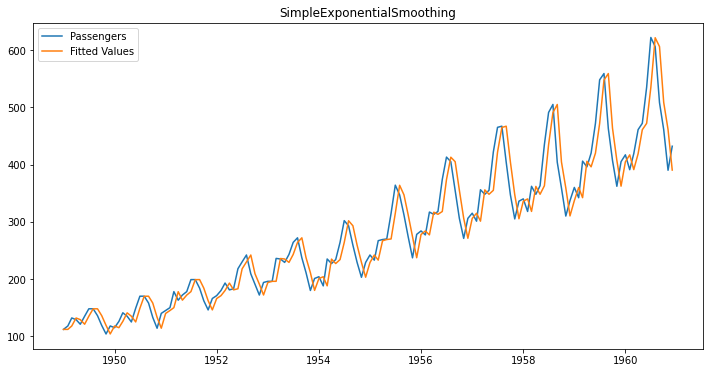

In [46]:
plt.plot(passengers_df, label='Passengers')
plt.plot(ses_fit.fittedvalues, label='Fitted Values')
plt.title('SimpleExponentialSmoothing')
plt.legend();

## Holt

In [47]:
holt = Holt(passengers_df)
holt_fit = holt.fit(optimized=True)
compare_df.loc['Holt'] = [holt_fit.sse, holt_fit.aic]
holt_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,#Passengers,No. Observations:,144
Model:,Holt,SSE,163019.276
Optimized:,True,AIC,1020.581
Trend:,Additive,BIC,1032.460
Seasonal:,None,AICC,1021.194
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:35
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9950209,alpha,True
smoothing_trend,0.0042555,beta,True


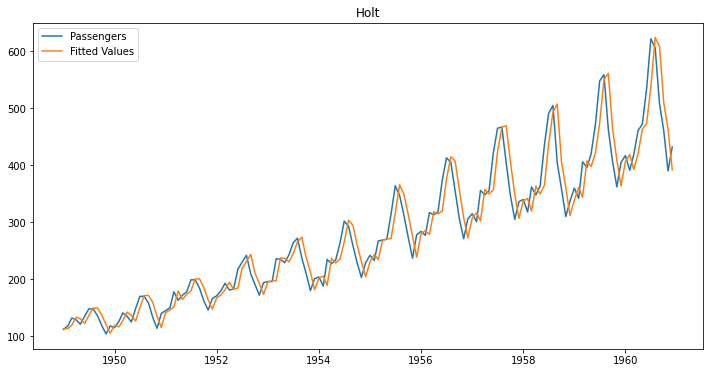

In [48]:
plt.plot(passengers_df, label='Passengers')
plt.plot(holt_fit.fittedvalues, label='Fitted Values')
plt.title('Holt')
plt.legend();

## Holt-Winters

In [49]:
hw = ExponentialSmoothing(passengers_df, trend='multiplicative', seasonal='multiplicative')
hw_fit = hw.fit(optimized=True)
compare_df.loc['HoltWinters'] = [hw_fit.sse, hw_fit.aic]
hw_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Dep. Variable:,#Passengers,No. Observations:,144
Model:,ExponentialSmoothing,SSE,15805.302
Optimized:,True,AIC,708.553
Trend:,Multiplicative,BIC,756.070
Seasonal:,Multiplicative,AICC,714.025
Seasonal Periods:,12,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:36
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2918958,alpha,True
smoothing_trend,2.4691e-07,beta,True


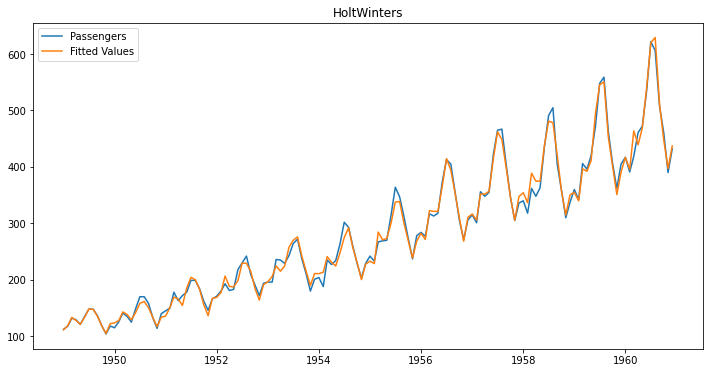

In [50]:
plt.plot(passengers_df, label='Passengers')
plt.plot(hw_fit.fittedvalues, label='Fitted Values')
plt.title('HoltWinters')
plt.legend();

## ETSModel

In [51]:
ets = ETSModel(passengers_df['#Passengers'], error='additive', trend='multiplicative', seasonal='multiplicative')
ets_fit = ets.fit(maxiter=10000)
compare_df.loc['ETS Model (AMM)'] = [ets_fit.sse, ets_fit.aic]
ets_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                       ETS(AMM)   Log Likelihood                -527.393
Date:                Thu, 19 May 2022   AIC                           1090.785
Time:                        13:15:38   BIC                           1144.242
Sample:                    01-01-1949   HQIC                          1112.507
                         - 12-01-1960   Scale                           88.856
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6687      0.078      8.596      0.000       0.516       0.821
smoothing_trend      6.687e-05        nan        nan        nan         nan         nan
smoothing_seasonal   3.313e-05        nan        nan        nan         nan         nan
initial_level         124.6691        nan        nan        nan         nan         nan
initial_trend           1.0084        nan        nan        nan         nan         nan
initial_seasonal.0      0.9765        nan        nan        nan         nan         nan
initial_seasonal.1      0.8801        nan        nan        nan         nan         nan
initial_seasonal.2      1.0186        nan        nan        nan         nan         nan
initial_seasonal.3      1.1630        nan        nan        nan         nan         nan
initial_seasonal.4      1.3778        nan        nan        nan         nan         nan
initial_seasonal.5      1.3917        nan        nan        nan         nan         nan
initial_seasonal.6      1.2383        nan        nan        nan         nan         nan
initial_seasonal.7      1.0865        nan        nan        nan         nan         nan
initial_seasonal.8      1.0695        nan        nan        nan         nan         nan
initial_seasonal.9      1.0814        nan        nan        nan         nan         nan
initial_seasonal.10     0.9516        nan        nan        nan         nan         nan
initial_seasonal.11     1.0000        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (Q):                       59.99   Jarque-Bera (JB):                 5.20
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               1.70   Skew:                            -0.15
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

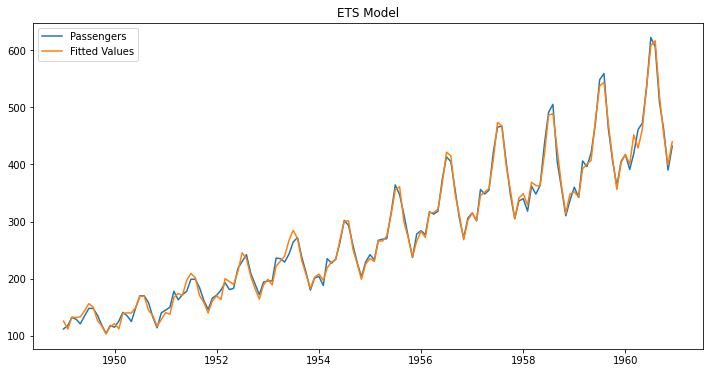

In [52]:
plt.plot(passengers_df, label='Passengers')
plt.plot(ets_fit.fittedvalues, label='Fitted Values')
plt.title('ETS Model')
plt.legend();

## Compare

In [53]:
compare_df['MSE'] = compare_df.SSE / len(passengers_df)
compare_df['RMSE'] = compare_df.MSE ** 0.5
compare_df.sort_values('SSE')

,SSE,AIC,MSE,RMSE
ETS Model (AMM),12795.306496,1090.785236,88.856295,9.426362
HoltWinters,15805.302381,708.553394,109.759044,10.476595
SimpleExponentialSmoothing,163003.353126,1016.566636,1131.967730,33.644728
Holt,163019.276177,1020.580702,1132.078307,33.646371


# Comparison - Sunspots

In [54]:
compare_df = pd.DataFrame(columns=['SSE', 'AIC'])

## Simple Exponential Smoothing

In [55]:
ses = SimpleExpSmoothing(sunspots_df)
ses_fit = ses.fit(optimized=True)
compare_df.loc['SimpleExponentialSmoothing'] = [ses_fit.sse, ses_fit.aic]
ses_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,Sunspots,No. Observations:,2820
Model:,SimpleExpSmoothing,SSE,716119.661
Optimized:,True,AIC,15618.651
Trend:,None,BIC,15630.540
Seasonal:,None,AICC,15618.666
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:39
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5294210,alpha,True
initial_level,61.741124,l.0,True


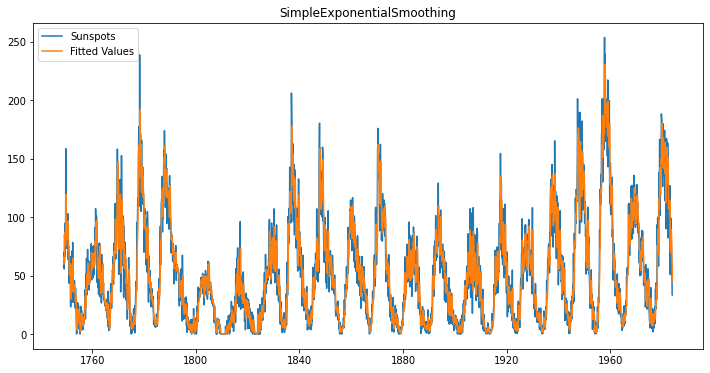

In [56]:
plt.plot(sunspots_df, label='Sunspots')
plt.plot(ses_fit.fittedvalues, label='Fitted Values')
plt.title('SimpleExponentialSmoothing')
plt.legend();

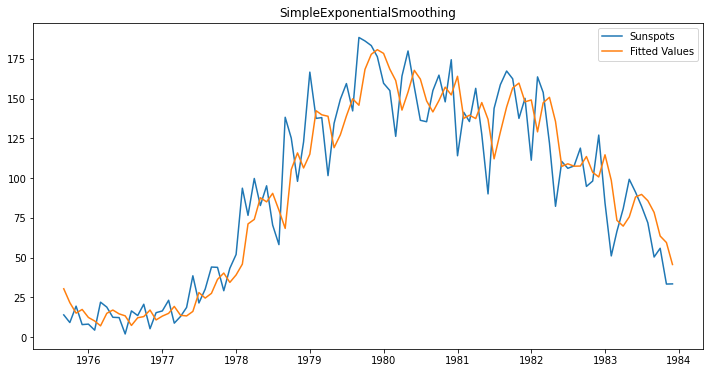

In [57]:
plt.plot(sunspots_df[-100:], label='Sunspots')
plt.plot(ses_fit.fittedvalues[-100:], label='Fitted Values')
plt.title('SimpleExponentialSmoothing')
plt.legend();

## Holt

In [58]:
holt = Holt(sunspots_df)
holt_fit = holt.fit(optimized=True)
compare_df.loc['Holt'] = [holt_fit.sse, holt_fit.aic]
holt_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,Sunspots,No. Observations:,2820
Model:,Holt,SSE,724500.562
Optimized:,True,AIC,15655.463
Trend:,Additive,BIC,15679.241
Seasonal:,None,AICC,15655.493
Seasonal Periods:,None,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:40
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5256833,alpha,True
smoothing_trend,0.0172804,beta,True


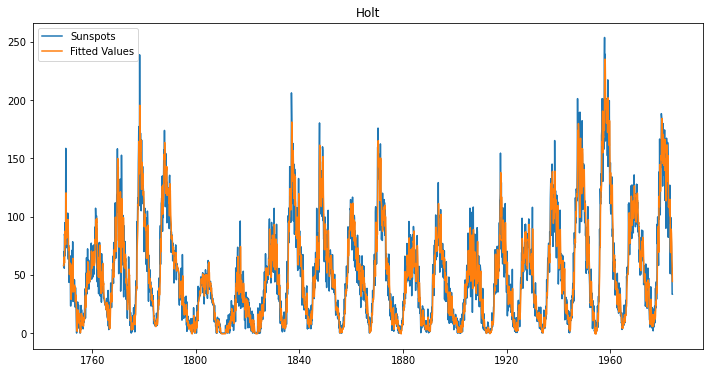

In [59]:
plt.plot(sunspots_df, label='Sunspots')
plt.plot(holt_fit.fittedvalues, label='Fitted Values')
plt.title('Holt')
plt.legend();

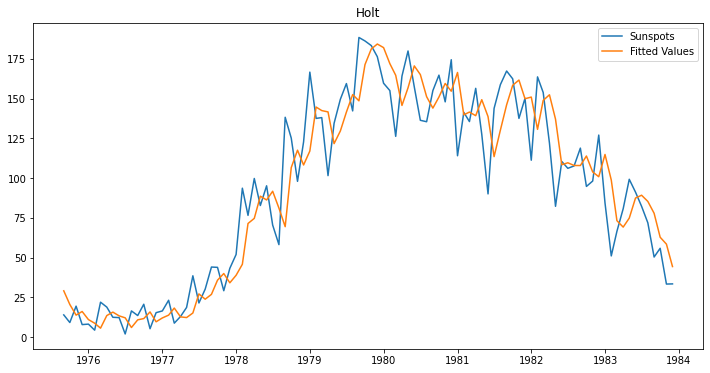

In [60]:
plt.plot(sunspots_df[-100:], label='Sunspots')
plt.plot(holt_fit.fittedvalues[-100:], label='Fitted Values')
plt.title('Holt')
plt.legend();

## Holt-Winters

In [61]:
hw = ExponentialSmoothing(sunspots_df, trend='additive', seasonal='additive')
hw_fit = hw.fit(optimized=True)
compare_df.loc['HoltWinters'] = [hw_fit.sse, hw_fit.aic]
hw_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Dep. Variable:,Sunspots,No. Observations:,2820
Model:,ExponentialSmoothing,SSE,739042.673
Optimized:,True,AIC,15735.505
Trend:,Additive,BIC,15830.617
Seasonal:,Additive,AICC,15735.749
Seasonal Periods:,12,Date:,"Thu, 19 May 2022"
Box-Cox:,False,Time:,13:15:43
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4975317,alpha,True
smoothing_trend,0.0322987,beta,True


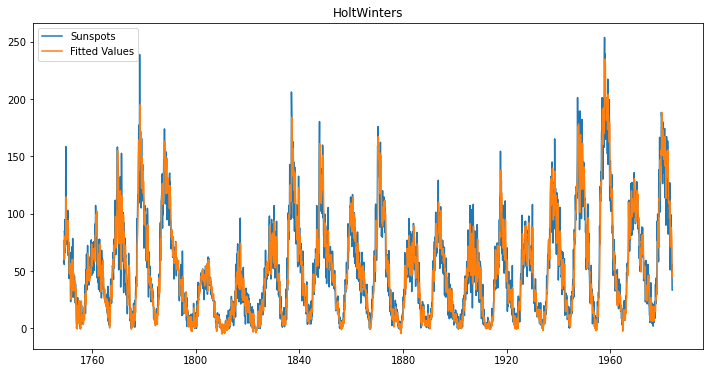

In [62]:
plt.plot(sunspots_df, label='Sunspots')
plt.plot(hw_fit.fittedvalues, label='Fitted Values')
plt.title('HoltWinters')
plt.legend();

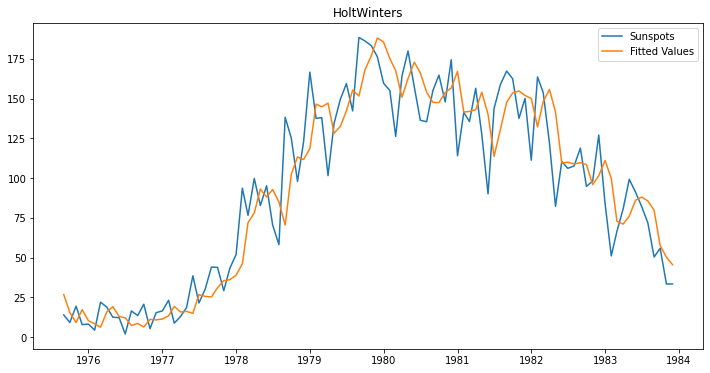

In [63]:
plt.plot(sunspots_df[-100:], label='Sunspots')
plt.plot(hw_fit.fittedvalues[-100:], label='Fitted Values')
plt.title('HoltWinters')
plt.legend();

## ETSModel

In [64]:
ets = ETSModel(sunspots_df['Sunspots'], error='additive', trend='additive', seasonal='additive')
ets_fit = ets.fit(maxiter=10000)
compare_df.loc['ETS Model (AAA)'] = [ets_fit.sse, ets_fit.aic]
ets_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Sunspots   No. Observations:                 2820
Model:                       ETS(AAA)   Log Likelihood              -11803.686
Date:                Thu, 19 May 2022   AIC                          23643.373
Time:                        13:15:51   BIC                          23750.374
Sample:                    01-01-1749   HQIC                         23681.982
                         - 12-01-1983   Scale                          253.036
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5302      0.019     28.478      0.000       0.494       0.567
smoothing_trend      5.302e-05        nan        nan        nan         nan         nan
smoothing_seasonal   4.698e-05        nan        nan        nan         nan         nan
initial_level          77.9952     12.981      6.008      0.000      52.553     103.438
initial_trend          -0.0135      0.182     -0.075      0.941      -0.369       0.342
initial_seasonal.0      2.4940      1.383      1.804      0.071      -0.216       5.204
initial_seasonal.1      1.6598      1.386      1.198      0.231      -1.056       4.376
initial_seasonal.2      2.8294      1.256      2.254      0.024       0.369       5.290
initial_seasonal.3      3.3088      1.359      2.435      0.015       0.646       5.972
initial_seasonal.4      3.0980      1.403      2.208      0.027       0.348       5.848
initial_seasonal.5      2.4927      1.394      1.789      0.074      -0.239       5.224
initial_seasonal.6      2.4997      1.390      1.798      0.072      -0.225       5.225
initial_seasonal.7      3.4366      1.393      2.468      0.014       0.707       6.166
initial_seasonal.8      1.9307      1.393      1.386      0.166      -0.799       4.661
initial_seasonal.9      0.9692      1.383      0.701      0.484      -1.742       3.680
initial_seasonal.10     2.0669      1.372      1.506      0.132      -0.622       4.756
initial_seasonal.11          0      1.359          0      1.000      -2.663       2.663
===================================================================================
Ljung-Box (Q):                      137.84   Jarque-Bera (JB):              1358.53
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.40   Skew:                             0.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+17. Standard errors may be unstable.
"""

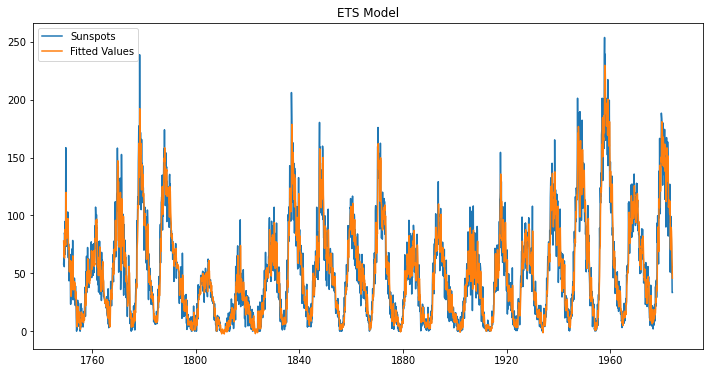

In [65]:
plt.plot(sunspots_df, label='Sunspots')
plt.plot(ets_fit.fittedvalues, label='Fitted Values')
plt.title('ETS Model')
plt.legend();

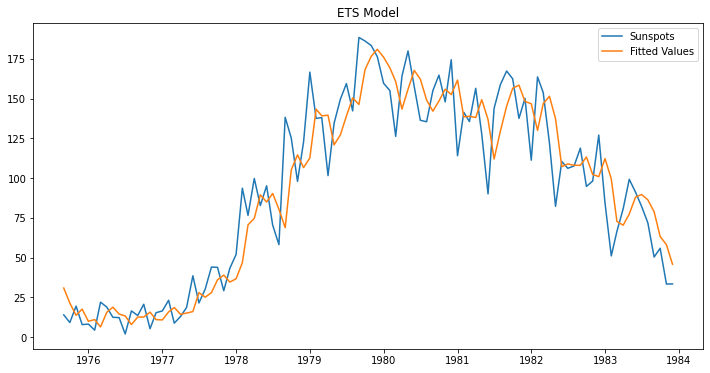

In [66]:
plt.plot(sunspots_df[-100:], label='Sunspots')
plt.plot(ets_fit.fittedvalues[-100:], label='Fitted Values')
plt.title('ETS Model')
plt.legend();

## ETSModel - 11 Year Cycle

In [67]:
ets_11 = ETSModel(sunspots_df['Sunspots'], error='additive', trend='additive', seasonal='additive', seasonal_periods=11*12)
ets_11_fit = ets_11.fit(maxiter=10000)
compare_df.loc['ETS Model (AAA) 11 Year'] = [ets_11_fit.sse, ets_11_fit.aic]
ets_11_fit.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               Sunspots   No. Observations:                 2820
Model:                       ETS(AAA)   Log Likelihood              -11725.416
Date:                Thu, 19 May 2022   AIC                          23726.832
Time:                        13:16:37   BIC                          24547.172
Sample:                    01-01-1749   HQIC                         24022.836
                         - 12-01-1983   Scale                          239.372
Covariance Type:               approx                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
smoothing_level          0.5178      0.020     26.510      0.000       0.480       0.556
smoothing_trend       5.178e-05        nan        nan        nan         nan         nan
smoothing_seasonal    4.822e-05        nan        nan        nan         nan         nan
initial_level           45.7790     14.625      3.130      0.002      17.114      74.444
initial_trend           -0.0099      0.167     -0.059      0.953      -0.338       0.318
initial_seasonal.0       3.1897      6.291      0.507      0.612      -9.141      15.520
initial_seasonal.1      -0.2401      6.284     -0.038      0.970     -12.556      12.076
initial_seasonal.2       6.0320      6.274      0.961      0.336      -6.265      18.329
initial_seasonal.3       5.3778      6.240      0.862      0.389      -6.852      17.607
initial_seasonal.4      -2.7274      6.243     -0.437      0.662     -14.963       9.508
initial_seasonal.5      -3.4225      6.238     -0.549      0.583     -15.648       8.803
initial_seasonal.6      -0.3306      6.224     -0.053      0.958     -12.530      11.869
initial_seasonal.7      -3.7159      6.211     -0.598      0.550     -15.889       8.457
initial_seasonal.8     -14.3608      6.208     -2.313      0.021     -26.528      -2.193
initial_seasonal.9      -9.5284      6.198     -1.537      0.124     -21.677       2.620
initial_seasonal.10     -5.5152      6.204     -0.889      0.374     -17.674       6.644
initial_seasonal.11     -3.7876      6.203     -0.611      0.541     -15.946       8.370
initial_seasonal.12     -7.6257      6.192     -1.232      0.218     -19.762       4.511
initial_seasonal.13     -6.3612      6.184     -1.029      0.304     -18.482       5.759
initial_seasonal.14     -2.0806      6.180     -0.337      0.736     -14.193      10.032
initial_seasonal.15      1.3863      6.204      0.223      0.823     -10.773      13.545
initial_seasonal.16    -13.3807      6.211     -2.154      0.031     -25.555      -1.207
initial_seasonal.17    -12.7987      6.219     -2.058      0.040     -24.988      -0.609
initial_seasonal.18    -15.9426      6.224     -2.561      0.010     -28.142      -3.743
initial_seasonal.19    -13.1744      6.224     -2.117      0.034     -25.374      -0.975
initial_seasonal.20    -11.2560      6.231     -1.807      0.071     -23.468       0.956
initial_seasonal.21    -17.8876      6.233     -2.870      0.004     -30.104      -5.671
initial_seasonal.22    -18.6262      6.227     -2.991      0.003     -30.832      -6.421
initial_seasonal.23    -23.4193      6.188     -3.785      0.000     -35.547     -11.291
initial_seasonal.24    -18.0346      6.187     -2.915      0.004     -30.160      -5.909
initial_seasonal.25    -22.7995      6.230     -3.660      0.000     -35.010     -10.588
initial_seasonal.26    -25.8320      6.240     -4.139      0.000     -38.063     -13.601
initial_seasonal.27    -29.6670      6.243     -4.752      0.000     -41.902     -17.431
initial_seasonal.28    -29.6510      

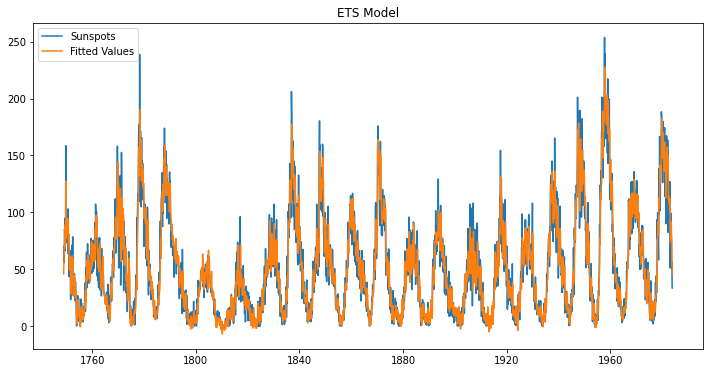

In [68]:
plt.plot(sunspots_df, label='Sunspots')
plt.plot(ets_11_fit.fittedvalues, label='Fitted Values')
plt.title('ETS Model')
plt.legend();

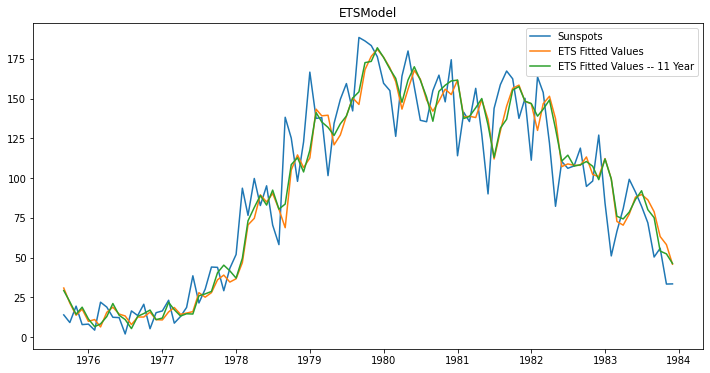

In [69]:
plt.plot(sunspots_df[-100:], label='Sunspots')
plt.plot(ets_fit.fittedvalues[-100:], label='ETS Fitted Values')
plt.plot(ets_11_fit.fittedvalues[-100:], label='ETS Fitted Values -- 11 Year')
plt.title('ETSModel')
plt.legend();

## Compare

In [70]:
compare_df['MSE'] = compare_df.SSE / len(sunspots_df)
compare_df['RMSE'] = compare_df.MSE ** 0.5
compare_df.sort_values('RMSE')

,SSE,AIC,MSE,RMSE
ETS Model (AAA) 11 Year,675030.360449,23726.831936,239.372468,15.471667
ETS Model (AAA),713561.455636,23643.372667,253.035977,15.907105
SimpleExponentialSmoothing,716119.660871,15618.651306,253.943142,15.935594
Holt,724500.562045,15655.462740,256.915093,16.028571
HoltWinters,739042.672533,15735.504954,262.071870,16.188634
